# 3. Dimensionality Reduction and Clustering

In the previous notebook, we could rely on labels which supervised the learning algorithm.
Next, we consider the unsupervised setting and knowledge discovery. We focus on the idea
of identifying a subset of relevant dimensions which capture the most variation in the data. 
This is closely related to the idea of compression.

In this notebook, we cover

* Principal Component Analysis (PCA) for dimensionality reduction
* k-means clustering 
* Gaussian Mixture Models (GMMs)

and apply these techniques to simulated data and two dataset examples (digit recognition).

Keywords:  ```MNIST```, ```np.linalg.eig```, ```sklearn.decomposition.PCA```, ```sklearn.cluster.KMeans```, 
 ```sklearn.mixture.GaussianMixture```

***

## Dimensionality Reduction 

The topic of dimensionality reduction plays a vital role in Machine Learning. Typically, our
datasets collect a great number of predictors or covariates or consist of images with hundreds of 
pixels. Getting an idea of the input space and relevant features is challenging in these high-dimensional
problems. Three main use cases include:

1. **Identifying relevant features / dimensions** in the input space which as much as possible preserves the variance in the data. In the following simplified example, the black arrows indicate the dimensions of highest variance: <center><img src="images/PCA_example.png" alt="PCA Example" width="300"/></center> The longer arrow can be viewed as the **main direction / dimension of variance** which accounts for about 90% of total variance and thus as the "more relevant" feature.

2. **Data compression**: In many applications we can reduce the number of dimensions to capture the relevant information. In the previous image, we might choose the longer arrow as a compressed version of our data. Another compression example is shown in the next image: <center><img src="images/Compression.png" alt="Image compression with Fast Fourier Transform" width="700"/></center> Here, we encoded an image of Maxim's cat (with an approach called *Fast Fourier Transformation*) into a much lower dimensional compressed image which only requires 9% of pixels compared to the original image. Decoding this compressed image reconstructs the orginial image almost perfectly.

3. **Visualising** high-dimensional data is generally difficult for dimensions larger than 3. Thus, dimensionality reduction is an important tool for visualisation and identifying patterns.

***

## Principal Component Analysis

Principal Component Analysis (PCA) ([Wikipeda](https://en.wikipedia.org/wiki/Principal_component_analysis)) is such a standard technique used for the above purposes and is of great relevance in a great variety of different disciplines. 

Let us generate simple 2-dimensional dataset to identify the main dimensions of variation.

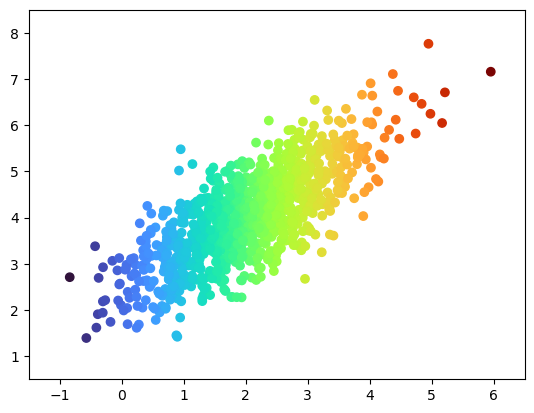

In [35]:
import numpy as np 
import matplotlib.pyplot as plt

np.random.seed(123)

num_datapoints = 1000

mu_generation = [2,4]
covariance_matrix_generation = np.array([[1,    0.75],
                                         [0.75, 1,  ]
                                        ])

gauss_2d_rotated = np.random.multivariate_normal(mean=mu_generation, 
                                                 cov=covariance_matrix_generation, 
                                                 size=num_datapoints)

plt.scatter(gauss_2d_rotated[:,0], gauss_2d_rotated[:,1], c=gauss_2d_rotated[:,0], cmap='turbo')

plt.ylim(0.5,8.5)
plt.xlim(-1.5,6.5)

plt.show()

The fundamental idea of PCA is to perform an eigendecomposition on the data covariance matrix $\text{cov}(X,X)$.
If our dataset $X$ is **centered**, i.e. the mean of all datapoints $N$ is 0, we can write the (sample) covariance matrix as

\begin{equation}
    \text{cov}(X,X) = \frac{1}{N-1} XX^\top.
\end{equation}

The corresponding eigenvectors to the largest eigenvalues of this matrix provide the
main axes of variation (principle components) in our dataset $X$.

Let's calculate these for our example and start by centering the dataset.

In [36]:
data_mean = np.mean(gauss_2d_rotated, axis=0)
data_centered = gauss_2d_rotated - data_mean

Next, calculate the eigenvalues and eigenvectors using ```np.linalg.eig``` and sort them in descending order.

In [37]:
cov_matrix = np.cov(data_centered, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

Let's compare the calculated covariance and the covariance matrix we used to generate the data:

In [38]:
print(f"Calculated covariance:\n{cov_matrix}\n\nCovariance used for generation:\n{covariance_matrix_generation}")

Calculated covariance:
[[0.98354551 0.74236276]
 [0.74236276 0.97100139]]

Covariance used for generation:
[[1.   0.75]
 [0.75 1.  ]]


Choose the two eigenvectors with the highest eigenvalues and project the data onto these vectors.
These are our "new" x- and y-axes.

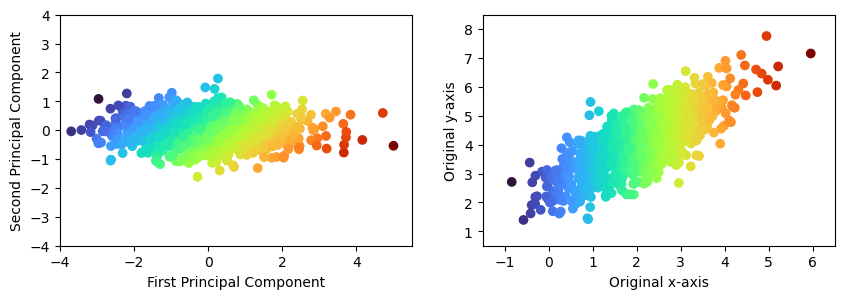

In [39]:
data_pca_transform = np.dot(data_centered, eigenvectors[:, :2])

fig, axs = plt.subplots(1,2, figsize=(10,3))

axs[0].scatter(data_pca_transform[:, 0], data_pca_transform[:, 1], c=gauss_2d_rotated[:,0], cmap='turbo')

axs[0].set_xlabel('First Principal Component')
axs[0].set_ylabel('Second Principal Component')
axs[0].set_xlim(-4,5.5)
axs[0].set_ylim(-4,4)

axs[1].scatter(gauss_2d_rotated[:,0], gauss_2d_rotated[:,1], c=gauss_2d_rotated[:,0], cmap='turbo')

axs[1].set_xlabel('Original x-axis')
axs[1].set_ylabel('Original y-axis')
axs[1].set_ylim(0.5,8.5)
axs[1].set_xlim(-1.5,6.5)

plt.show()

#### Note 
that in this 2d example, the **projection on the two eigenvectors corresponds to a rotation** of our dataset.
This will be different, if the original dataset has more dimensions.

### As before, we can just use ```scikit-learn``` 
and its functionality with the function [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)!

In [40]:
from sklearn.decomposition import PCA

num_eigvectors = 2

data_pca = PCA(n_components=num_eigvectors)
data_pca.fit(gauss_2d_rotated)

data_pca_transform = data_pca.transform(gauss_2d_rotated)

We can even check the explained variance ratio of the first two principal components:

In [41]:
print(data_pca.explained_variance_ratio_)

[0.87982678 0.12017322]


### MNIST Example 
As a first, more interesting example, we examine the MNIST dataset!

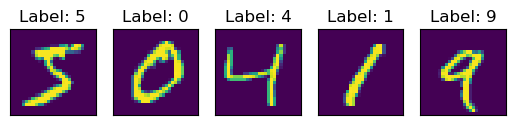

In [42]:
mnist_data = np.load('data/mnist_data_5k.npy', allow_pickle=True)
mnist_targets = np.load('data/mnist_labels_5k.npy', allow_pickle=True)

fig, axs = plt.subplots(1,5)

for i, ax in enumerate(axs.ravel()):
    ax.imshow(mnist_data[i].reshape(28,28))
    
    ax.set_title(f"Label: {mnist_targets[i]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

Let's see what the projection on the first two eigenvectors looks like in MNIST:

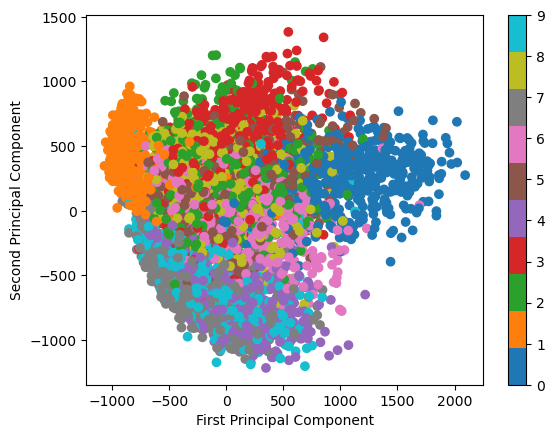

In [67]:
data_pca = PCA(n_components=2)
data_pca.fit(mnist_data)
data_pca_transform_mnist = data_pca.transform(mnist_data)

plt.scatter(data_pca_transform_mnist[:, 0], data_pca_transform_mnist[:, 1], c=mnist_targets, cmap='tab10')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar()
plt.show()

The result shows that **similar numbers are clustered** and thus that samples from the **same class share similar features**.

Let's examine the explained variance ratios:

In [51]:
print(data_pca.explained_variance_ratio_)

[0.09867566 0.07404546]


These two dimensions account for **less than 20% of the variance**. In other words,
we might miss about 80% of relevant variation in our data and should not base our 
computation solely on these first two principal components!

***

## Clustering

Another important approach to identifying patterns in an unsupervised fashion is clustering. In the previous examples,
we have already seen instances where datapoints might form clusters indicating similar features.

Two popular approaches to clustering are **k-means** and **Gaussian Mixture Models** which we consider in the following.

#### k-means

The underlying idea of k-means ([Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering)) is assign datapoints to $k$ cluster means / centroids in the dataset. The following GIF illustrates this for $k=3$ centroids:

<center><img src="images/K-means_convergence.gif" alt="k-means" width="400"/> <br> GIF source: <a href="https://en.wikipedia.org/wiki/K-means_clustering#/media/File:K-means_convergence.gif">Wikipedia</a> <br> </center>

More formally, we consider a set of $N$ datapoints $X=(x_1, ..., x_N)$ which we try to group into 
$k$ groups forming sets $S_1, S_2, ..., S_k$. The objective function is given by

\begin{equation}
    \text{argmin}_{S} \sum_{i=1}^{k} \sum_{x\in S_i} \Vert x - \mu_i \Vert ^2
\end{equation}

where $\mu_i = \frac{1}{\vert S_i \vert} \sum_{x\in S_i} x$ is the mean of the datapoints in 
cluster $S_i$.

The algorithm **starts** with placing the cluster means / centroids $\mu_i$ in a random position 
(see GIF above at Iteration #0). Datapoints are assigned to the closest mean $\mu_i$, i.e. to 
cluster $S_i$, and a **new cluster mean** is calculated. The algorithm **iterates** this step several 
times until the cluster assignments remain unchanged.

#### Note
that in an unsupervised setting, **we generally do not know the number of clusters $k$**! Thus, 
$k$ is a *hyper-parameter* we need to choose!

Let's create a clustered dataset with two clusters of 100 datapoints each, i.e. $N=200$.

In [52]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

num_datapoints = 100

cluster_1 = np.random.normal( 2, 1, size=(num_datapoints, 2))
cluster_2 = np.random.normal(-2, 1, size=(num_datapoints, 2))

cluster_data = np.concatenate([cluster_1, cluster_2])


We make use of the ```scikit-learn``` implementation of [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and choose $k=2$.

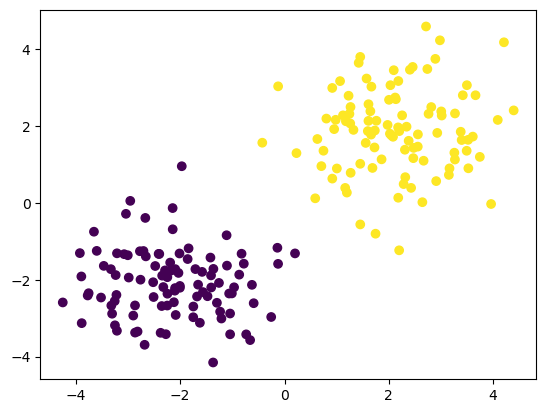

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [53]:
from sklearn.cluster import KMeans

k = 2

kmeans = KMeans(n_clusters=k, random_state=123, n_init=10)
kmeans.fit(cluster_data)

cluster_prediction = kmeans.predict(cluster_data)

plt.scatter(cluster_data[:,0], cluster_data[:,1], c=cluster_prediction)
plt.show()

print(cluster_prediction)

### Gaussian Mixture Model 

A Gaussian Mixture Model (GMM) ([Wikipedia](https://en.wikipedia.org/wiki/Mixture_model)) can be 
viewed as a (probabilistic) relaxation of k-means. Instead of "hard" cluster assignments, we 
consider "soft" assignments by means of probabilities. 

An GMM assumes a mixture of several Gaussian distributions as the underlying distribution for 
the dataset and observed clustering (which can be a strong assumption, in practice). Each Gaussian 
distribution $\mathcal{N}(\mu_i, \Sigma_i)$ forms a cluster and is characterized by mean $\mu_i$ 
and covariance matrix $\Sigma_i$. The GMM (prior) distribution is then given by the mixture model

\begin{equation}
    p(\mu,\Sigma) = \sum_{i=1}^k w_i \mathcal{N}(\mu_i, \Sigma_i)
\end{equation}

where $\mu = (\mu_1, ..., \mu_k)$, $\Sigma = (\Sigma_1, ..., \Sigma_k)$, and $w=(w_1,...,w_k)$ is 
the weighting of the different mixture components.

As before, we start by choosing a number of $k$ clusters and setting the parameters $\mu,\Sigma$ to some
initial values. The cluster assignment and parameters are then updated iteratively with the 
**expectation-maximisation (EM) algorithm** until cluster assignments, i.e. the parameters $\mu,\Sigma$, 
do not change any longer.

Let's consider the same dataset as for k-means and make use of the ```scikit-learn``` 
[GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) method.

In [54]:
from sklearn.mixture import GaussianMixture

k = 2

GMM = GaussianMixture(n_components=k)
GMM.fit(cluster_data)

GaussianMixture(n_components=2)

In order to provide the probabilities, we need to obtain a grid of datapoints
which can do with ```numpy.meshgrid```.

In [55]:
x_min = cluster_data[:, 0].min() - 1
x_max = cluster_data[:, 0].max() + 1

y_min = cluster_data[:, 1].min() - 1
y_max = cluster_data[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
                     np.linspace(y_min, y_max, 100))

Finally, we can obtain the probability predictions with ```score_samples``` and plot the results.
Note that this method provides the log-likelihood, i.e. we need to exponentiate 
these outputs!

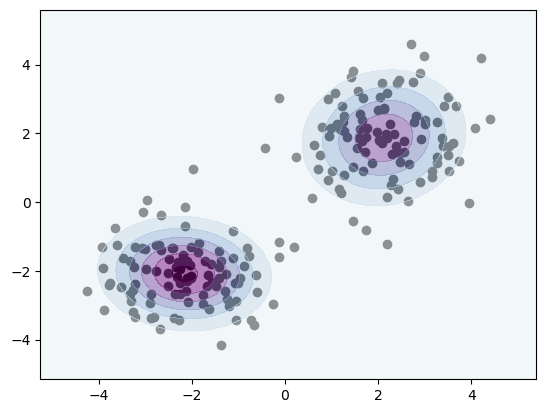

In [56]:
probab = GMM.score_samples(np.c_[xx.ravel(), yy.ravel()])
probab = np.exp(probab)
probab = probab.reshape(xx.shape)

plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c='black')
plt.contourf(xx, yy, probab, alpha=0.6, cmap='BuPu')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

#### Note
that ```np.c_[A,B]``` concatenates NumPy arrays ```A``` and ```B```
along the second axis.

***

## Exercise Section

In the next two exercises, we use k-means and a Gaussian Mixture Model on the projection 
of the MNIST data on its two first principal components.

(1.) Firstly, to simplify the clustering task, we will only consider digits ```0```, ```3```, 
```6```, and ```9```. For this make us of ```%3``` to identify all of these labels in
```mnist_targets``` and select only the respective elements in ```data_pca_transform_mnist```
and ```mnist_targets``` (defined above). Provide the filtered datasets ```ex_data``` and the corresponding
labels in ```ex_targets``` in the following cell.

In [ ]:
ex_data = # fill in
ex_targets = # fill in 

If you were successful, you can plot the filtered dataset below,
which should look like the following plot:

<center><img src="images/MNIST_filtered.png" alt="MNIST Filtered" width="400"/></center>

In [ ]:
plt.scatter(ex_data[:, 0], ex_data[:, 1], c=ex_targets, cmap='tab10')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar()
plt.show()

(2.) Implement a k-means approach for clustering ```ex_data``` and provide the 
k-means object as ```kmeans``` and cluster predictions in ```cluster_prediction```.

In [ ]:
# fill in

Use ```cluster_prediction``` and the above defined ```kmeans``` to plot 
the clusters with the following cell.

In [ ]:
plt.scatter(ex_data[:,0], ex_data[:,1], c=cluster_prediction)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='X', c='red')
plt.show()

(3.) Implement an Gaussian Mixture Model approach for clustering ```ex_data```. Provide the 
Gaussian Mixture Model as object ```GMM```, the grid coordinates ```xx``` and ```yy``` (as seen before)
and the predictions in ```probab```.

In [ ]:
# fill in

If you have defined ```GMM```, ```xx```, ```yy```, and ```probab``` in the cell,
the next cell will allow you to plot your result.

In [ ]:
plt.scatter(ex_data[:, 0], ex_data[:, 1], c='black')
plt.contourf(xx, yy, probab, alpha=0.6, cmap='BuPu')
plt.scatter(GMM.means_[:,0],GMM.means_[:,1], marker='X', c='orange')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

***

## Proposed Solutions

In the next two exercises, we use k-means and a Gaussian Mixture Model on the projection 
of the MNIST data on its two first principal components.

(1.) Firstly, to simplify the clustering task, we will only consider digits ```0```, ```3```, 
```6```, and ```9```. For this make us of ```%3``` to identify all of these labels in
```mnist_targets``` and select only the respective elements in ```data_pca_transform_mnist```
and ```mnist_targets``` (defined above). Provide the filtered datasets ```ex_data``` and the corresponding
labels in ```ex_targets``` in the following cell

In [61]:
ex_data = data_pca_transform_mnist[mnist_targets%3==0]
ex_targets = mnist_targets[mnist_targets%3==0]

If you were successful, you can plot the filtered dataset below,
which should look like the following plot:

<center><img src="images/MNIST_filtered.png" alt="MNIST Filtered" width="400"/></center>

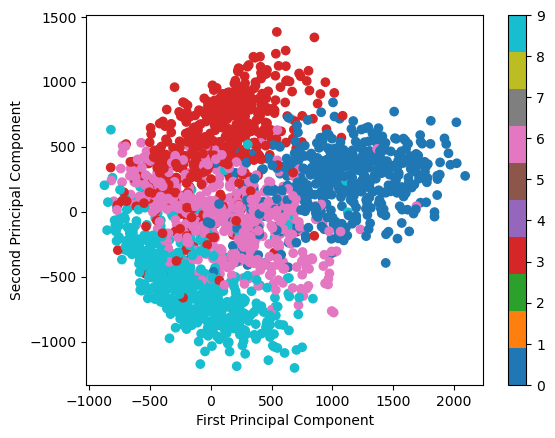

In [62]:
plt.scatter(ex_data[:, 0], ex_data[:, 1], c=ex_targets, cmap='tab10')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar()
plt.show()

(2.) Implement an k-means approach for clustering ```ex_data``` and provide the 
k-means object as ```kmeans``` and cluster predictions in ```cluster_prediction```.

In [63]:
from sklearn.cluster import KMeans

k = 4

kmeans = KMeans(n_clusters=k, random_state=123)
kmeans.fit(ex_data)

cluster_prediction = kmeans.predict(ex_data)

/Users/samarinm/anaconda3/APML/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Use ```cluster_prediction``` and the above defined ```kmeans``` to plot 
the clusters with the following cell.

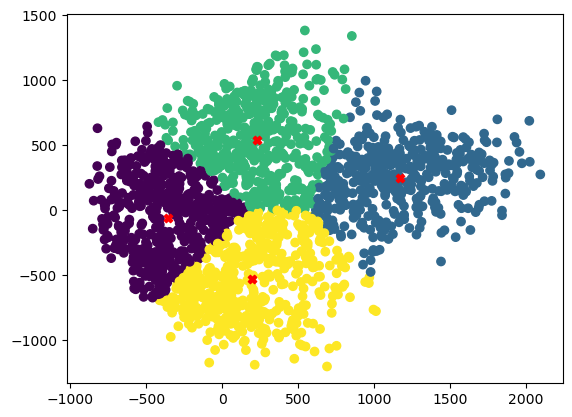

In [64]:
plt.scatter(ex_data[:,0], ex_data[:,1], c=cluster_prediction)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='X', c='red')
plt.show()

(3.) Implement an Gaussian Mixture Model approach for clustering ```ex_data```. Provide the 
Gaussian Mixture Model as object ```GMM```, the grid coordinates ```xx``` and ```yy``` (as seen before)
and the predictions in ```probab```.

In [65]:
from sklearn.mixture import GaussianMixture

k = 4

GMM = GaussianMixture(n_components=k)
GMM.fit(ex_data)

x_min = ex_data[:, 0].min() - 1
x_max = ex_data[:, 0].max() + 1

y_min = ex_data[:, 1].min() - 1
y_max = ex_data[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
                     np.linspace(y_min, y_max, 100))

probab = GMM.score_samples(np.c_[xx.ravel(), yy.ravel()])
probab = np.exp(probab)
probab = probab.reshape(xx.shape)

If you have defined ```GMM```, ```xx```, ```yy```, and ```probab``` in the cell,
the next cell will allow you to plot your result.

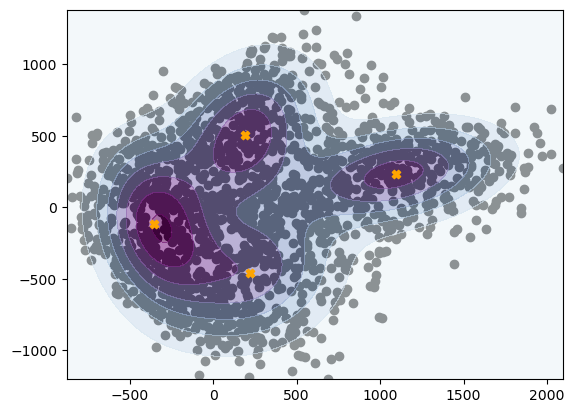

In [66]:
plt.scatter(ex_data[:, 0], ex_data[:, 1], c='black')
plt.contourf(xx, yy, probab, alpha=0.6, cmap='BuPu')
plt.scatter(GMM.means_[:,0],GMM.means_[:,1], marker='X', c='orange')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

In [68]:
print(f"GMM cluster means = \n{GMM.means_}\n")
print(f"k-means cluster means = \n{kmeans.cluster_centers_}")

GMM cluster means = 
[[ 189.23099224  509.27570034]
 [-353.88608806 -119.44188012]
 [1096.73107558  233.27452475]
 [ 221.6598133  -461.5002517 ]]

k-means cluster means = 
[[-358.65060915  -62.02974473]
 [1172.16601688  245.21903822]
 [ 231.10451936  539.90273125]
 [ 197.0679518  -531.87250621]]
